Found this Breast Cancer dataset and wanted to play around with modeling. Code Utilizes Scikit learn packaged, KNN,.

In [ ]:
import pandas as pd

data_dir = "http://dlsun.github.io/pods/data/"
df_breast = pd.read_csv(data_dir + "breast-cancer.csv")
df_breast.head()

,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,0
1,1002945,5,4,4,5,7,10,3,2,1,0
2,1015425,3,1,1,1,2,2,3,1,1,0
3,1016277,6,8,8,1,3,4,3,7,1,0
4,1017023,4,1,1,3,2,1,3,1,1,0


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

X_train = df_breast[["Clump Thickness", "Uniformity of Cell Size", "Uniformity of Cell Shape",
                     "Marginal Adhesion", "Single Epithelial Cell Size", "Bare Nuclei",
                     "Bland Chromatin", "Normal Nucleoli", "Mitoses"]]
y_train = df_breast["Class"]

model = KNeighborsClassifier(n_neighbors=10)
model.fit(X=X_train, y=y_train)

KNeighborsClassifier(n_neighbors=10)

 Calculating the model's predictions on the training data, and calculate how often the prediction matches the ground truth.

In [ ]:
y_train_ = model.predict(X_train)
accuracy = (y_train_ == y_train).mean()
accuracy

0.9736456808199122

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_train_)

0.9736456808199122

The accuracy is 97.4%, which sounds impressive. But it would be less impressive if 97.4% of all samples in the data were benign, since the same accuracy could be achieved by a useless model that predicts that every sample is benign.

The problem with a model that predicts that every sample is benign is that, although the model might be accurate overall, it is very inaccurate for malignant samples. We want a model that is not just accurate overall, but accurate for both benign and malignant samples. There is some ambiguity in how to define "accuracy for malignant samples". As a result, there are two metrics: _precision_ and _recall_.

Precision and Recall for KNN Model

In [ ]:
true_positives = ((y_train_ == 1) & (y_train == 1)).sum()

precision = true_positives / (y_train_ == 1).sum()
recall = true_positives / (y_train == 1).sum()

precision, recall

(0.9662447257383966, 0.9581589958158996)

In [ ]:
from sklearn.metrics import precision_score, recall_score

(precision_score(y_train == 0, y_train_ == 0),
 recall_score(y_train == 0, y_train_ == 0))

(0.9775784753363229, 0.9819819819819819)

Explicitly specify the class. Malignant masses have lower precision and recall

In [ ]:
(precision_score(y_train == 1, y_train_ == 1),
 recall_score(y_train == 1, y_train_ == 1))

(0.9662447257383966, 0.9581589958158996)

There are only two classes, so I predict that a breast mass is malignant if the predicted probability of malignancy is $0.5$ or higher. (I predict it is benign otherwise). Instead of using $0.5$ as the threshold, I could cast a wider net for malignancy by lowering the threshold to $0.4$, predicting a breast mass to be malignant as long as the predicted probability is $0.4$ or higher.

In [ ]:
probas_ = model.predict_proba(X_train)
probas_

array([[1. , 0. ],
       [0.1, 0.9],
       [1. , 0. ],
       ...,
       [0. , 1. ],
       [0. , 1. ],
       [0. , 1. ]])

In [ ]:
y_train_ = (probas_[:, 1] >= 0.4)

(precision_score(y_train == 1, y_train_ == 1),
 recall_score(y_train == 1, y_train_ == 1))

(0.948, 0.9916317991631799)

I see that recall increases to 99.2% when we cast this wider net, at the expense of precision, which drops to 94.8%.

<AxesSubplot:xlabel='recall'>

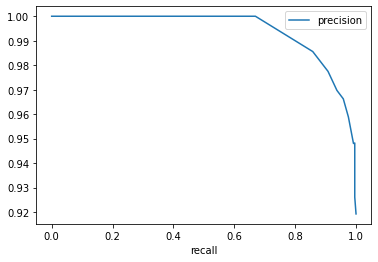

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(
    y_train == 1, probas_[:, 1]
)

pd.DataFrame({
    "precision": precisions,
    "recall": recalls
}).plot.line(x="recall", y="precision")

This curve makes the tradeoff between precision and recall explicit. As I lower the threshold, the recall for malignant masses increases from 0% to 100%, while the precision decreases from 100% to about 92%.

I can also plot the precision-recall curve for benign masses.

<AxesSubplot:xlabel='recall'>

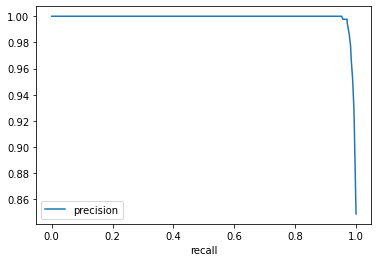

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(
    y_train == 0, probas_[:, 0]
)

pd.DataFrame({
    "precision": precisions,
    "recall": recalls
}).plot.line(x="recall", y="precision")

F1 score to combine precision and recall

In [ ]:
2 * precision * recall / (precision + recall)

0.9621848739495799